# illumination estimation

The task of illumination estimation involves determining the lighting conditions present in a given image or video frame. This includes information about the color, direction, and intensity of the light sources that are illuminating the scene.

Illumination estimation is an important task in computer vision and graphics, as it can be used to improve the quality of images and videos, and enable more accurate analysis and recognition of objects and scenes. For example, in applications such as autonomous driving, surveillance, and augmented reality, accurate illumination estimation can help to identify and track objects more effectively under varying lighting conditions.

There are various approaches to illumination estimation, including statistical models, physical-based models, and learning-based methods. These methods typically involve analyzing the brightness, color, and texture of the image or video frames, and using this information to estimate the lighting conditions. The accuracy of illumination estimation can depend on factors such as the complexity of the scene, the quality of the image or video, and the specific method used.

![Illumination estimation](figs/01.png)

The input to an illumination estimation algorithm is typically an image or a video frame. This input can be in various formats, such as RGB. 

The output of the algorithm is typically a set of parameters that describe the lighting conditions present in the image or video frame. These parameters can be in various formats, such as RGB, HSV, or XYZ.

## Example

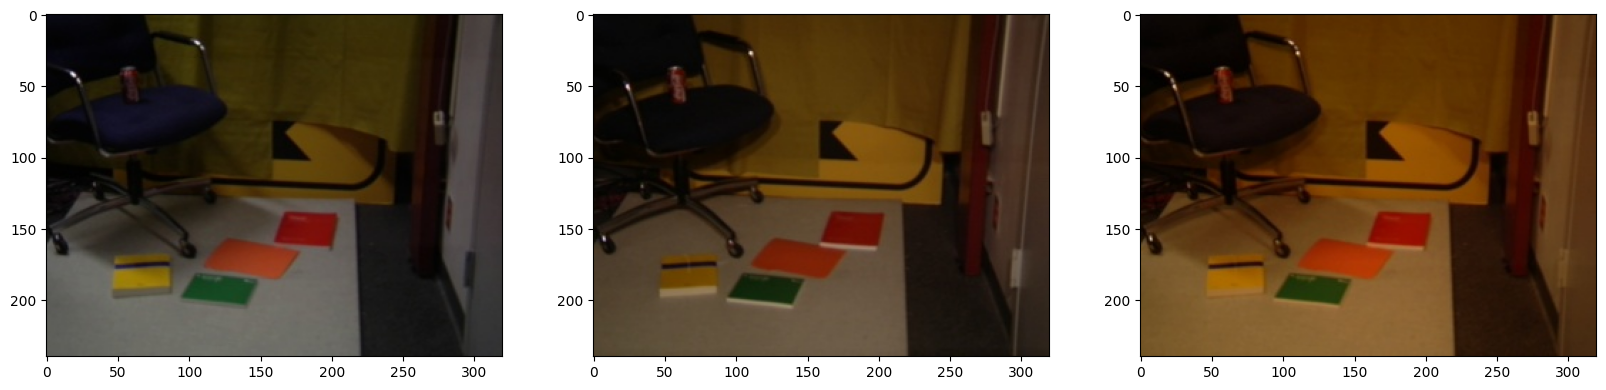

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

image_paths = os.listdir('data/test')
f, axarr = plt.subplots(1, len(image_paths), figsize=(20, 20))

for i, img_path in enumerate(image_paths):
    image = cv2.imread('data/test/' + img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axarr[i].imshow(image)

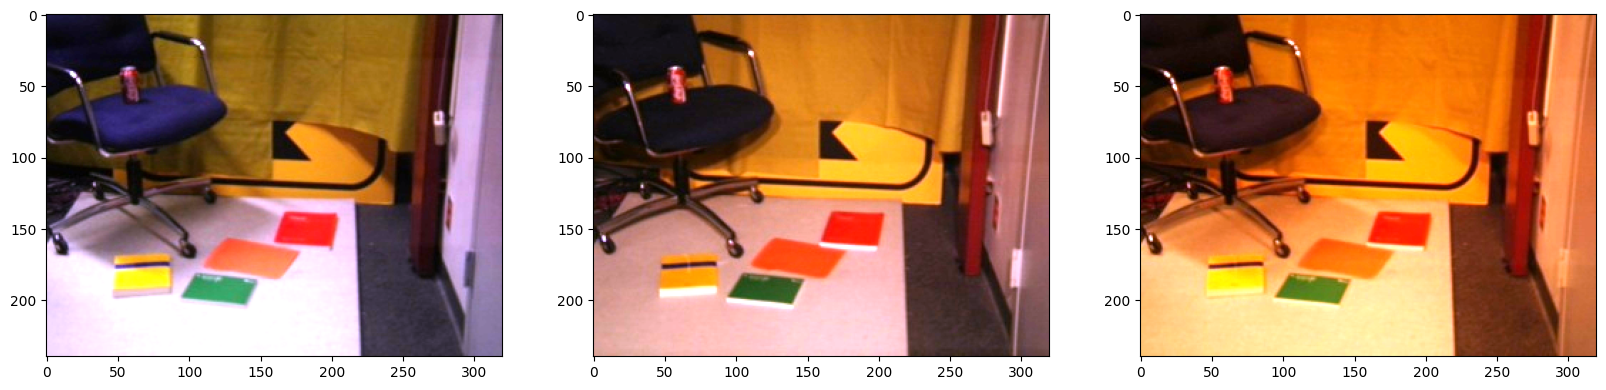

In [2]:
color_constancy = [0.38, 0.431, 0.32]
f, axarr = plt.subplots(1, len(image_paths), figsize=(20, 20))

for i, img_path in enumerate(image_paths):
    image = cv2.imread('data/test/' + img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    image = image / color_constancy
    axarr[i].imshow(image.clip(0, 1))

## Metrics

1. Mean Angular Error (MAE): This measures the difference between the estimated illumination direction and the ground truth illumination direction, using angular distance as the metric. A lower MAE indicates better color constancy.

2. Reproduction Angular Error (RAE) is a metric used to evaluate the performance of color constancy algorithms. RAE measures the angular difference between the estimated illumination direction and the ground truth illumination direction after the color correction has been applied to the image.

In [3]:
def angular_error(gt, pred):
    '''Angular Error between two vectors.'''
    v1 = np.array(gt) / np.linalg.norm(gt, ord=2)
    v2 = np.array(pred) / np.linalg.norm(pred, ord=2)
    return np.arccos((v1*v2).sum().clip(-1, 1)) / np.pi * 180

def repr_ang_error(gt, pred):
    """Calc reproduction angular error. See "Finlayson, Graham D., and Roshanak Zakizadeh. Reproduction angular
        error: An improved performance metric for illuminant estimation." 
    In the IEC#1 arguments order was mistakenly swapped. It slightly changed metric values within the same competitors' solutions order. 
    """
    err = angular_error([1, 1, 1], gt / pred)
    return err

gt = np.array([0.38, 0.431, 0.32])
pred = np.array([0.7, 0.5, 0.1])
print('Angular error: ', angular_error(gt, pred))
print('Reproduction angular error: ', repr_ang_error(gt, pred))

Angular error:  25.638450340947852
Reproduction angular error:  37.65808987435038


## Dataset: Simple Cub++ Dataset

Cube++ is a novel dataset for the color constancy problem that continues on the Cube+ dataset. It includes 4890 images of different scenes under various conditions. For calculating the ground truth illumination, a calibration object with known surface colors was placed in every scene. The Cube++ dataset was used in ICMV 2020 2nd Illumination Estimation Challenge.

### SimpleCube++

Simple dataset contains 4x downscaled images that have less than 1° difference between left and right ground truth illumination estimation. It includes only 2234 images with single source illumination; consequently, there is only one ground truth per image. The simple dataset weights around 2GB.

Small dataset contains PNG and JPG files, gt.csv with ground truth data and properties.csv with manual annotation data:
* **train**
    * **PNG/{img_id}.png** – 16-bit PNG images with cropped cube area
    * **gt.csv** – Ground truth chromaticities answers. Ground truth file. The table contains automatically calculated ground truth values. The columns are: image (contains image id) and three columns r, g, b with the corresponding RGB illumination estimation. The illumination estimation is normalized so that `r + g + b = 1`
* **test** – The same format
    * **PNG/{img_id}.png**
    * **gt.csv**
* **auxiliary**
    * **{test/train}_properties.csv** – Annotation and metadata file. The table contains the most relevant meta information of the dataset images. It includes image column (contains image id), ds_version (0.0 for Cube images; 1.0 for Cube+ extension and IEC2019 test images; 2.0 for Cube++ extension), manually labeled properties (only daytime; place; illumination; is_sharp; shadows)
    * **JPG/{test/train}_{img_id}.jpg** – JPEG images with cropped cube area, for visualization purposes only

Angular error:  1.2074182697257333e-06
Reproduction angular error:  0.0


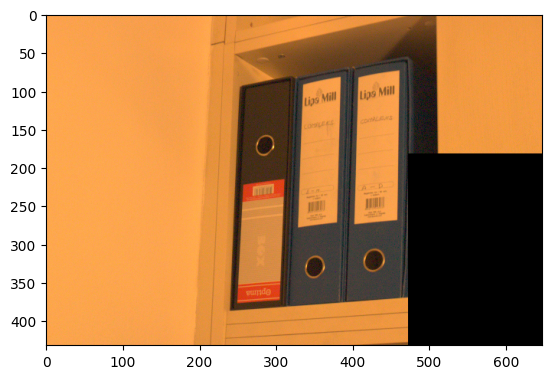

In [4]:
def linearize(img, black_lvl=2048, saturation_lvl=2**14-1):
    """
    :param saturation_lvl: 2**14-1 is a common value. Not all images
                           have the same value.
    """
    return np.clip((img - black_lvl)/(saturation_lvl - black_lvl), 0, 1)

cam2rgb = np.array([
        1.8795, -1.0326, 0.1531,
        -0.2198, 1.7153, -0.4955,
        0.0069, -0.5150, 1.5081,]).reshape((3, 3))

illum_gt = np.array([0.19930239889614626,0.4692735155569186,0.3314240855469353])

image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
image = np.clip(image/illum_gt, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum_gt, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum_gt, illum_gt))

## Gray World
The Gray World Algorithm (GWA) is a simple color constancy algorithm that assumes that, on average, the colors in an image should have equal mean values across the red, green, and blue color channels. In other words, it assumes that the scene being photographed has a neutral color balance.

The GWA works by estimating the average color of the image and using this estimate to scale the individual color channels so that they have equal mean values.

The result of the algorithm is an image with color channels that have been scaled so that they have equal mean values. This scaling adjusts for the color shift introduced by different lighting conditions, assuming that the average color of the image is representative of the true colors of the scene.

The Gray World Algorithm is simple and computationally efficient, but it makes strong assumptions about the scene being photographed and may not work well in cases where the scene has an uneven color balance or where there are strong color cast effects due to lighting conditions. However, it can be a useful baseline algorithm for evaluating the performance of more advanced color constancy algorithms.

In [5]:
def gray_world(image):
    """
    Applies the Gray World Algorithm to an input RGB image.

    Args:
        image: numpy array of shape (height, width, 3) representing the input image

    Returns:
        RGB values of the estimated illuminant
    """

    # Compute average color of the image
    avg_color = np.mean(np.mean(image, axis=0), axis=0)

    return avg_color

Angular error:  24.490389826087547
Reproduction angular error:  28.680071616860037


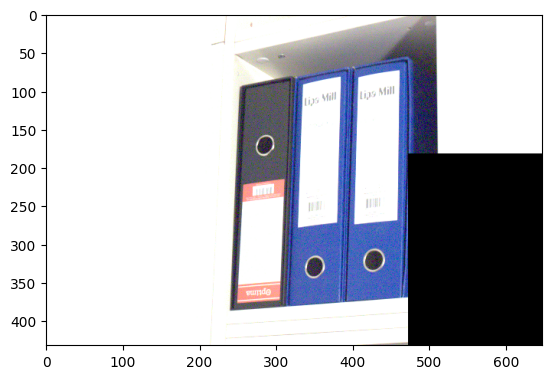

In [6]:
image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
illum = gray_world(image)
image = np.clip(image/illum, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum, illum_gt))

## Max RGB

The Max-RGB algorithm is a color constancy algorithm based on the assumption that the brightest channel in an image is likely to correspond to a white or gray surface in the scene being photographed. The algorithm works by first identifying the brightest channel in the image, and then scaling the other channels so that they have the same maximum value as the brightest channel.

The result of this algorithm is an image with color channels that have been scaled so that they have the same maximum value as the brightest channel, which is assumed to correspond to a white or gray surface in the scene.

The Max-RGB algorithm is simple and computationally efficient and can be effective in cases where the scene being photographed has a white or gray surface that can be used as a reference point for color correction. However, it may not work well in cases where the brightest channel does not correspond to a white or gray surface, or where there are color-cast solid effects due to lighting conditions.

In [7]:
def max_rgb(image):
    """
    Applies the Max-RGB algorithm to an input RGB image.

    Args:
        image: numpy array of shape (height, width, 3) representing the input image

    Returns:
        corrected_image: numpy array of shape (3,) representing the RGB correction vector
    """

    # Compute the maximum value for each color channel of the input image
    max_values = np.max(np.max(image, axis=0), axis=0)

    return max_values

Angular error:  26.83022063093031
Reproduction angular error:  30.759516301955152


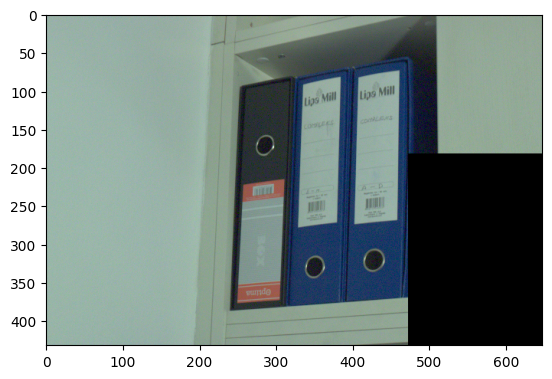

In [8]:
image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
illum = max_rgb(image)
image = np.clip(image/illum, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum, illum_gt))

## Gray Edge

The Gray Edge algorithm is a color constancy algorithm that is based on the observation that edges in an image tend to correspond to boundaries between different materials or surfaces with different reflectance properties. The algorithm works by first detecting edges in the image, and then using the average color of the edge pixels as a reference point for color correction.

The result of this algorithm is a gray world correction vector that can be used to correct the color balance of the input image.

The Gray Edge algorithm can be effective in cases where there are clear edges in the image that correspond to boundaries between different materials or surfaces with different reflectance properties. However, it may not work well in cases where the edges are not well-defined or where there are strong color cast effects due to lighting conditions.

In [9]:
import numpy as np
import cv2

def gray_edge(
        img,
        norm_order = 1,
    ):
    """
    Applies the Gray Edge algorithm to an input RGB image.

    Args:
        image: numpy array of shape (height, width, 3) representing the input image
        threshold: integer threshold for the edge detection filter

    Returns:
        corrected_image: numpy array of shape (3,) representing the RGB correction vector
    """
    img = img.copy()
    scale = 1
    delta = 0
    ddepth = cv2.CV_64F

    gray = np.mean(img, axis=2, dtype=np.float64)
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    for i in range(3):
        img[:,:, i] = grad * img[:,:, i]

    flatten = img.reshape((-1, 3))
    ie = np.linalg.norm(flatten, axis=0, ord=norm_order)
    ie /= np.linalg.norm(ie, ord=1)
    return ie

Angular error:  26.46425007046345
Reproduction angular error:  30.46549668650638


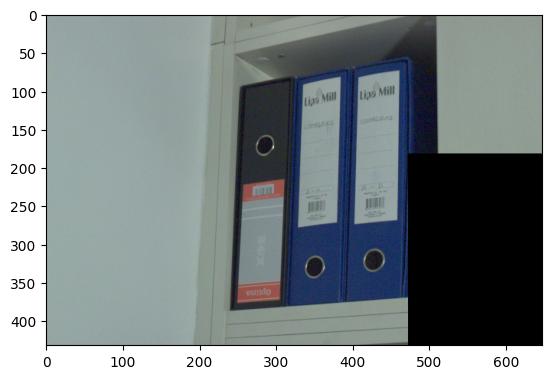

In [10]:
image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
illum = gray_edge(image)
image = np.clip(image/illum, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum, illum_gt))

## White Patch

The white patch algorithm is a color constancy method that estimates the illuminant color of an image by assuming that the brightest patch in the image should be white, or at least a neutral color under the illuminant.

The algorithm works as follows:

- Convert the input RGB image to a chromaticity representation, where each pixel is represented by a 2D vector that describes its color in terms of hue and saturation, but not its brightness.
- For each channel (R, G, and B), find the pixel with the highest chromaticity value in that channel, which corresponds to the brightest patch in the image under that channel. Let Cmax be the chromaticity value of the brightest patch in the channel that has the highest chromaticity value among the three channels.
- The illuminant color is estimated as the inverse of Cmax, i.e., the inverse of the chromaticity value of the brightest patch in the channel that has the highest chromaticity value.

The white patch algorithm assumes that the brightest patch in the image is illuminated by a white or neutral light source, and that the brightness of the patch is not affected by the surrounding scene. However, this assumption may not hold in images with high dynamic range or complex lighting conditions.

The white patch algorithm is simple and computationally efficient, but it may not work well in all situations. Variations of the algorithm have been proposed to address some of its limitations, such as the gray-world with brightest-pixel algorithm and the gray-edge algorithm

In [11]:
from skimage import color

def white_patch(img):
    # Convert the input image to chromaticity representation
    img_chroma = color.rgb2hsv(img)

    # Find the pixel with the highest chromaticity value in each channel
    max_chroma = np.amax(img_chroma, axis=(0, 1))

    return max_chroma

Angular error:  26.54035247349785
Reproduction angular error:  30.446263913373727


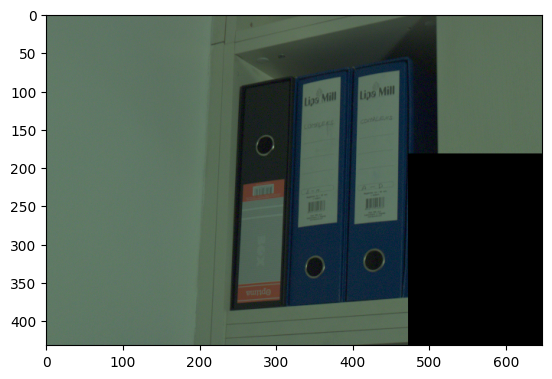

In [12]:
image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
illum = white_patch(image)
image = np.clip(image/illum, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum, illum_gt))

## Neural Networks
### Color Cerberus

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from ml.dataset import CubePPLoader
# Dataset preparation:

path_to_train = 'data/SimpleCube++/train/'
path_to_test = 'data/SimpleCube++/test/'

train_gen = CubePPLoader(
    'data/SimpleCube++/train/PNG', 
    'data/SimpleCube++/train/gt.csv'
)

test_gen = CubePPLoader(
    'data/SimpleCube++/test/PNG', 
    'data/SimpleCube++/test/gt.csv'
)

In [14]:
x, y = train_gen.__getitem__(0)
x.shape

(1, 96, 96, 3)

In [15]:
from ml.model import get_model

simple_conv_model = get_model()
simple_conv_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
simple_conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        2112      
                                                                 
 flatten (Flatten)           (None, 589824)            0         
                                                                 
 dense (Dense)               (None, 128)               75497600  
                                                                 
 dense_1 (Dense)             (None, 128)               16512 

In [23]:
simple_conv_model(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.00605418, 0.00053284, 0.0065356 ], dtype=float32)>

In [17]:
epochs = 1

history = simple_conv_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=test_gen, 
    workers=8
)

In [24]:
simple_conv_model.save('checkpoints/simple_conv_model.h5')

In [25]:
## load model
simple_conv_model = tf.keras.models.load_model('checkpoints/simple_conv_model.h5')
simple_conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        2112      
                                                                 
 flatten (Flatten)           (None, 589824)            0         
                                                                 
 dense (Dense)               (None, 128)               75497600  
                                                                 
 dense_1 (Dense)             (None, 128)               16512 

Angular error:  4.474104179851772
Reproduction angular error:  6.496619076694361


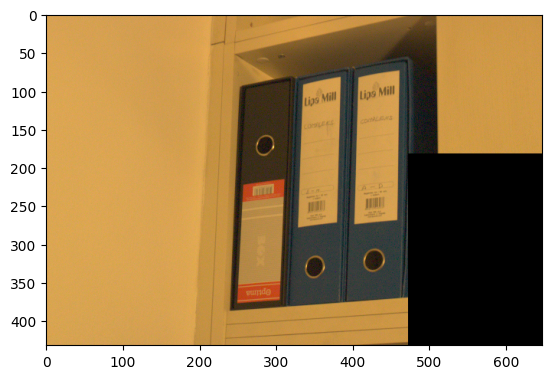

In [22]:
image = cv2.imread('data/SimpleCube++/test/PNG/00_0010.png', cv2.IMREAD_UNCHANGED)
image = linearize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64))
resized = cv2.resize(image, (96, 96)) / 255
illum = simple_conv_model.predict(np.expand_dims(resized, axis=0))[0].numpy()
image = np.clip(image/illum, 0, 1)
image = np.dot(image, cam2rgb.T)
image = np.clip(image, 0, 1)**(1/2.2)

plt.imshow(image)

print('Angular error: ', angular_error(illum, illum_gt))
print('Reproduction angular error: ', repr_ang_error(illum, illum_gt))

## Conclusion

Neural networks are the most accurate color constancy algorithms. However, they are also the most computationally expensive. The Gray World and Gray Edge algorithms are the simplest and most computationally efficient color constancy algorithms, but they make strong assumptions about the scene being photographed and may not work well in cases where the scene has an uneven color balance or where there are strong color cast effects due to lighting conditions.

### Results
- Gray World Algorithm (GWA):
    - Angular error:  24.490389826087547
    - Reproduction angular error:  28.680071616860037
- Max-RGB:
    - Angular error: 26.83022063093031
    - Reproduction angular error: 30.759516301955152
- Gray Edge:
    - Angular error: 26.46425007046345
    - Reproduction angular error: 30.46549668650638
- White Patch:
    - Angular error: 26.54035247349785
    - Reproduction angular error: 30.446263913373727
- Color Cerberus:
    - Angular error: 4.474104179851772
    - Reproduction angular error: 6.496619076694361